## XGBoost with mask Autoencoder 960-dimensional Embeddings

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gc
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

/home/richard/miniconda3/envs/esm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# First, let's examine the data structure to identify column names
def examine_dataframe(df):
    """Print the structure of the dataframe to identify column names"""
    print("DataFrame columns:", df.columns.tolist())
    print("First row sample:", df.iloc[0].to_dict())
    return df.columns.tolist()

# Get the absolute path of the current notebook
notebook_path = os.path.abspath('')

# Navigate to the project root (CS182-Final-Project)
project_root = os.path.dirname(notebook_path)
os.chdir(project_root)

print("Loading data...")
train_data = pickle.load(open('data/full_dataset/train_data.pkl', 'rb'))
cv_data = pickle.load(open('data/full_dataset/validation_data.pkl', 'rb'))
test1_data = pickle.load(open('data/full_dataset/test1_data.pkl', 'rb'))
test2_data = pickle.load(open('data/full_dataset/test2_data.pkl', 'rb'))

# Examine structure of the first dataframe to understand its format
print("\nExamining training data structure:")
examine_dataframe(train_data)

print("\nLoading TCN 512-dimensional protein embeddings...")
protein_embeddings = pickle.load(open('data/full_dataset/embeddings/compressed_protein_features.pkl', 'rb'))
print(f"Loaded {len(protein_embeddings)} protein embeddings")

print(train_data.head())
print("\nSample TCN embeddings:")
for i, (key, value) in enumerate(protein_embeddings.items()):
    if i >= 5:
        break
    print(f"Protein ID: {key}, Embedding shape: {value.shape}, Type: {type(value)}")

Loading data...

Examining training data structure:
DataFrame columns: ['uniprotID_A', 'uniprotID_B', 'isInteraction', 'trainTest', 'sequence_A', 'sequence_B']
First row sample: {'uniprotID_A': 'O43759', 'uniprotID_B': 'P59991', 'isInteraction': 0, 'trainTest': 'train', 'sequence_A': 'MEGGAYGAGKAGGAFDPYTLVRQPHTILRVVSWLFSIVVFGSIVNEGYLNSASEGEEFCIYNRNPNACSYGVAVGVLAFLTCLLYLALDVYFPQISSVKDRKKAVLSDIGVSAFWAFLWFVGFCYLANQWQVSKPKDNPLNEGTDAARAAIAFSFFSIFTWAGQAVLAFQRYQIGADSALFSQDYMDPSQDSSMPYAPYVEPTGPDPAGMGGTYQQPANTFDTEPQGYQSQGY', 'sequence_B': 'MCHTSCSSGCQPACCAPSPCQPACCVPSSCQASCCVPVGCQSSVCVPVSFKPAVCLPVSCQSSVCVPMSFKSAVCVPVSCQSSVCVPVSCRPIVCAAPSCQSSLCVPVSCRPVVYAAPSCQSSGCCQPSCTSVLCRPISYSISSCC'}

Loading TCN 512-dimensional protein embeddings...
Loaded 12026 protein embeddings
       uniprotID_A uniprotID_B  isInteraction trainTest  \
100353      O43759      P59991              0     train   
118225      P54646      Q13671              0     train   
89464       O15344      Q9H9B1              0     trai

In [5]:
def extract_embeddings_separate(data_df, embeddings_dict, batch_size=100):
    """Extract separate mask AE embeddings for protein A and B"""
    columns = data_df.columns.tolist()
    
    # Find column names (reuse existing logic)
    protein_a_col = None
    protein_b_col = None
    interaction_col = None
    
    protein_a_patterns = ['protein_a', 'protein_id_a', 'proteinA', 'proteinIDA', 'protein_A', 'protein_id_A', 'uniprotID_A']
    protein_b_patterns = ['protein_b', 'protein_id_b', 'proteinB', 'proteinIDB', 'protein_B', 'protein_id_B', 'uniprotID_B']
    interaction_patterns = ['isInteraction', 'is_interaction', 'interaction', 'label']
    
    for col in columns:
        col_lower = col.lower()
        if any(pattern.lower() in col_lower for pattern in protein_a_patterns):
            protein_a_col = col
        elif any(pattern.lower() in col_lower for pattern in protein_b_patterns):
            protein_b_col = col
        elif any(pattern.lower() in col_lower for pattern in interaction_patterns):
            interaction_col = col
    
    if protein_a_col is None or protein_b_col is None:
        first_row = data_df.iloc[0].to_dict()
        for col, val in first_row.items():
            if isinstance(val, str) and val in embeddings_dict:
                if protein_a_col is None:
                    protein_a_col = col
                elif protein_b_col is None and col != protein_a_col:
                    protein_b_col = col
    
    print(f"Using columns: Protein A = '{protein_a_col}', Protein B = '{protein_b_col}', Interaction = '{interaction_col}'")
    
    embA_list = []
    embB_list = []
    y_list = []
    skipped = 0
    
    for i in tqdm(range(0, len(data_df), batch_size), desc="Extracting Mask Autoencoder embeddings"):
        batch = data_df.iloc[i:i+batch_size]
        
        for _, row in batch.iterrows():
            protein_A = row[protein_a_col]
            protein_B = row[protein_b_col]
            
            if protein_A not in embeddings_dict or protein_B not in embeddings_dict:
                skipped += 1
                continue
            
            # TCN embeddings are already fixed-length 512-dimensional vectors
            embedding_A = embeddings_dict[protein_A]
            embedding_B = embeddings_dict[protein_B]
            
            # Convert to numpy if needed
            if isinstance(embedding_A, torch.Tensor):
                feat_A = embedding_A.cpu().numpy()
                feat_B = embedding_B.cpu().numpy()
            else:
                feat_A = embedding_A
                feat_B = embedding_B
            
            embA_list.append(feat_A)
            embB_list.append(feat_B)
            y_list.append(row[interaction_col])
    
    print(f"Processed {len(embA_list)} protein pairs. Skipped {skipped} pairs.")
    return np.array(embA_list), np.array(embB_list), np.array(y_list)

def create_features(embA, embB, method='all'):
    """Create combined features from protein embeddings"""
    if method == 'all':
        return np.concatenate([embA, embB, np.abs(embA - embB), embA * embB], axis=1)
    elif method == 'concatenate':
        return np.concatenate([embA, embB], axis=1)
    elif method == 'add_sub':
        return np.concatenate([embA + embB, embA - embB], axis=1)
    elif method == 'mul_only':
        return embA * embB
    elif method == 'abs_diff':
        return np.abs(embA - embB)
    else:
        raise ValueError(f"Unknown method: {method}")

# Extract separate embeddings for all datasets
print("\nLoading Mask Autoencoder 960-dimensional protein embeddings...")
train_embA, train_embB, train_y = extract_embeddings_separate(train_data, protein_embeddings)
val_embA, val_embB, val_y = extract_embeddings_separate(cv_data, protein_embeddings)
test1_embA, test1_embB, test1_y = extract_embeddings_separate(test1_data, protein_embeddings)
test2_embA, test2_embB, test2_y = extract_embeddings_separate(test2_data, protein_embeddings)

print(f"Train embeddings: A={train_embA.shape}, B={train_embB.shape}, y={train_y.shape}")
print(f"Val embeddings: A={val_embA.shape}, B={val_embB.shape}, y={val_y.shape}")
print(f"Test1 embeddings: A={test1_embA.shape}, B={test1_embB.shape}, y={test1_y.shape}")
print(f"Test2 embeddings: A={test2_embA.shape}, B={test2_embB.shape}, y={test2_y.shape}")


Loading Mask Autoencoder 960-dimensional protein embeddings...
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting Mask Autoencoder embeddings: 100%|██████████| 854/854 [00:01<00:00, 469.44it/s]


Processed 85329 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting Mask Autoencoder embeddings: 100%|██████████| 214/214 [00:00<00:00, 506.19it/s]


Processed 21333 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting Mask Autoencoder embeddings: 100%|██████████| 249/249 [00:00<00:00, 513.99it/s]


Processed 24898 protein pairs. Skipped 0 pairs.
Using columns: Protein A = 'uniprotID_A', Protein B = 'uniprotID_B', Interaction = 'isInteraction'


Extracting Mask Autoencoder embeddings: 100%|██████████| 1370/1370 [00:02<00:00, 538.29it/s]


Processed 136939 protein pairs. Skipped 0 pairs.
Train embeddings: A=(85329, 960), B=(85329, 960), y=(85329,)
Val embeddings: A=(21333, 960), B=(21333, 960), y=(21333,)
Test1 embeddings: A=(24898, 960), B=(24898, 960), y=(24898,)
Test2 embeddings: A=(136939, 960), B=(136939, 960), y=(136939,)


In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Test different feature combination methods
methods = ['concatenate', 'all', 'add_sub', 'mul_only', 'abs_diff']
best_score = 0
best_model = None
best_method = None
best_scaler = None

# XGBoost parameters optimized for the new embeddings
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'random_state': 42,
    'eval_metric': 'logloss'
}

results = {}

for method in methods:
    print(f"\n{'='*50}")
    print(f"Testing method: {method}")
    print(f"{'='*50}")
    
    # Create features using the specified method
    X_train = create_features(train_embA, train_embB, method=method)
    X_val = create_features(val_embA, val_embB, method=method)
    X_test1 = create_features(test1_embA, test1_embB, method=method)
    X_test2 = create_features(test2_embA, test2_embB, method=method)

    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test1_scaled = scaler.transform(X_test1)
    X_test2_scaled = scaler.transform(X_test2)
    
    # Create and fit XGBoost model
    xgb_model = xgb.XGBClassifier(**xgb_params)
    
    # Fit the model
    print("Training XGBoost model...")
    xgb_model.fit(X_train_scaled, train_y)
    
    # Validation predictions
    val_preds = xgb_model.predict(X_val_scaled)
    val_proba = xgb_model.predict_proba(X_val_scaled)[:, 1]
    
    # Calculate metrics
    val_acc = accuracy_score(val_y, val_preds)
    val_auc = roc_auc_score(val_y, val_proba)
    val_f1 = f1_score(val_y, val_preds)
    val_precision = precision_score(val_y, val_preds)
    val_recall = recall_score(val_y, val_preds)
    
    print(f"Validation Accuracy ({method}): {val_acc:.4f}")
    print(f"Validation AUC ({method}): {val_auc:.4f}")
    print(f"Validation F1 ({method}): {val_f1:.4f}")
    print(f"Validation Precision ({method}): {val_precision:.4f}")
    print(f"Validation Recall ({method}): {val_recall:.4f}")
    
    # Store results
    results[method] = {
        'accuracy': val_acc,
        'auc': val_auc,
        'f1': val_f1,
        'precision': val_precision,
        'recall': val_recall,
        'model': xgb_model,
        'scaler': scaler,
        'X_train_scaled': X_train_scaled,
        'X_val_scaled': X_val_scaled,
        'X_test1_scaled': X_test1_scaled,
        'X_test2_scaled': X_test2_scaled
    }

    if val_auc > best_score:
        best_score = val_auc
        best_model = xgb_model
        best_method = method
        best_scaler = scaler

print(f"\n{'='*60}")
print(f"BEST METHOD: {best_method} with auc: {best_score:.4f}")
print(f"{'='*60}")


Testing method: concatenate
X_train shape: (85329, 1920)
X_val shape: (21333, 1920)
Training XGBoost model...
Validation Accuracy (concatenate): 0.6315
Validation AUC (concatenate): 0.6897
Validation F1 (concatenate): 0.6386
Validation Precision (concatenate): 0.6265
Validation Recall (concatenate): 0.6510

Testing method: all
X_train shape: (85329, 3840)
X_val shape: (21333, 3840)
Training XGBoost model...
Validation Accuracy (all): 0.6295
Validation AUC (all): 0.6910
Validation F1 (all): 0.6248
Validation Precision (all): 0.6328
Validation Recall (all): 0.6169

Testing method: add_sub
X_train shape: (85329, 1920)
X_val shape: (21333, 1920)
Training XGBoost model...
Validation Accuracy (add_sub): 0.6243
Validation AUC (add_sub): 0.6790
Validation F1 (add_sub): 0.6200
Validation Precision (add_sub): 0.6271
Validation Recall (add_sub): 0.6131

Testing method: mul_only
X_train shape: (85329, 960)
X_val shape: (21333, 960)
Training XGBoost model...
Validation Accuracy (mul_only): 0.6219


TEST SET EVALUATION
Test1 Accuracy: 0.6128
Test1 AUROC: 0.6636
Test1 AUPRC: 0.6723
Test1 F1 Score: 0.6011
Test1 Precision: 0.6199
Test1 Recall: 0.5834

Test2 Accuracy: 0.6373
Test2 AUROC: 0.6636
Test2 AUPRC: 0.2020
Test2 F1 Score: 0.2238
Test2 Precision: 0.1389
Test2 Recall: 0.5753


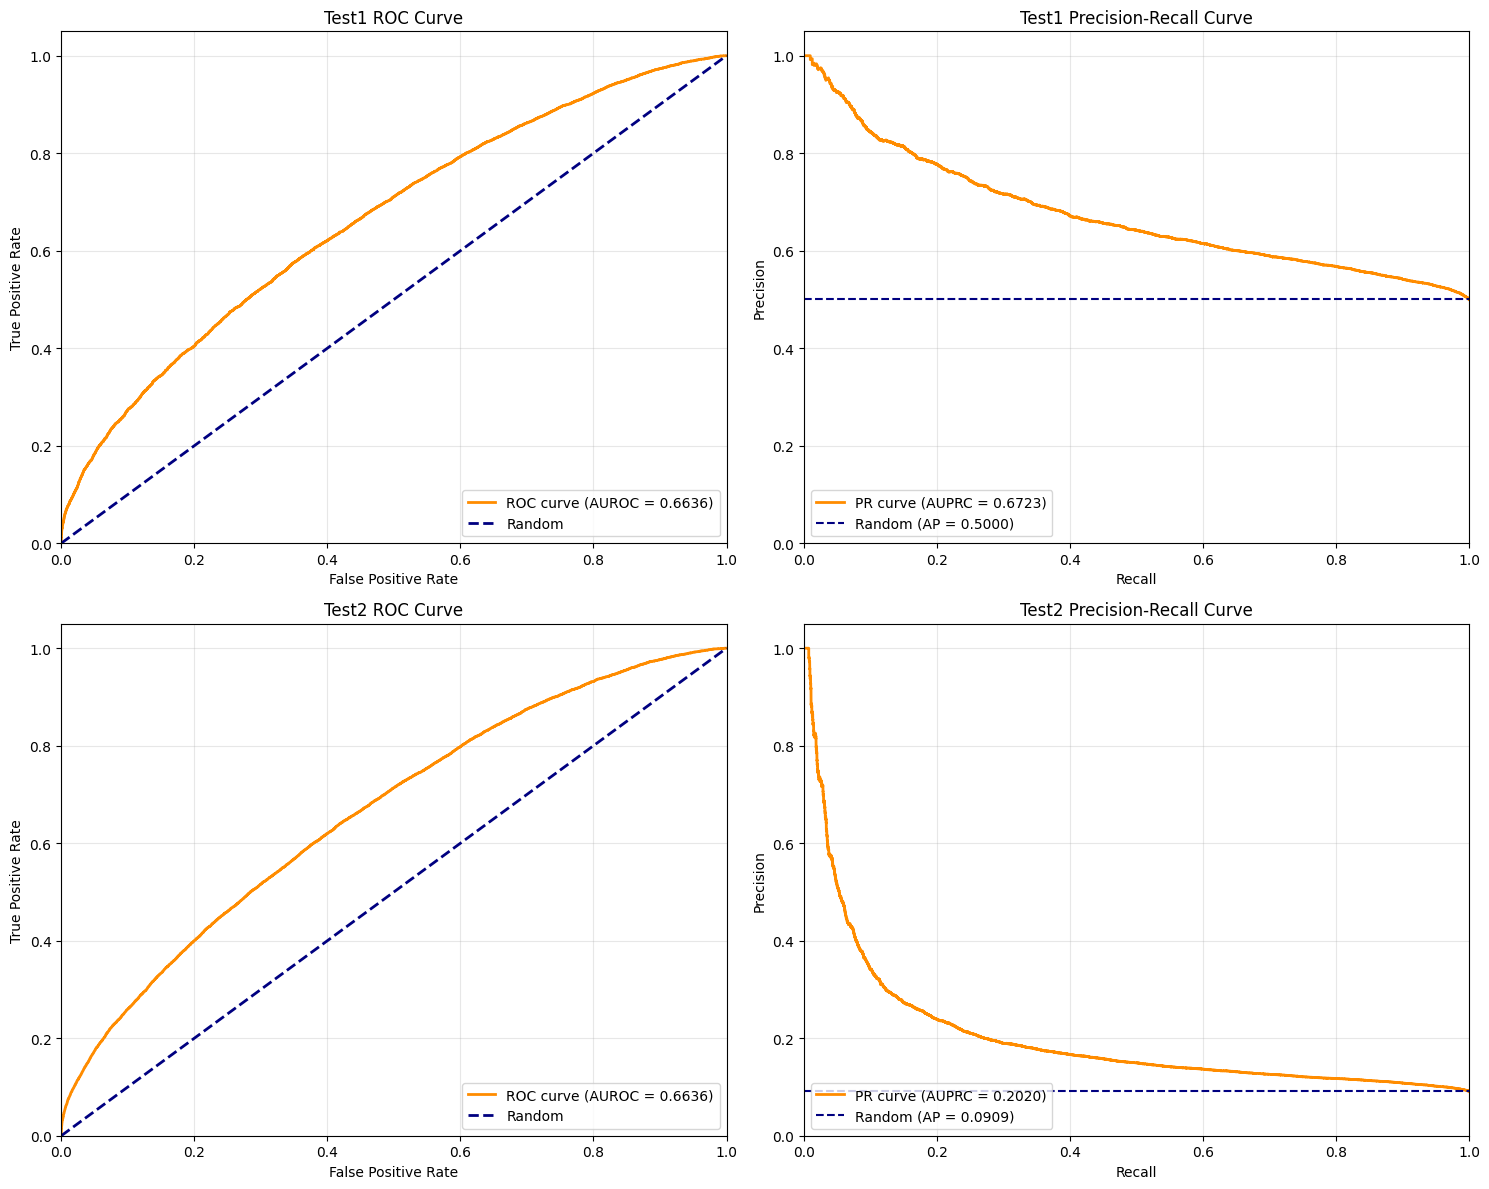


==================== Test1 Classification Report ====================
              precision    recall  f1-score   support

           0       0.61      0.64      0.62     12449
           1       0.62      0.58      0.60     12449

    accuracy                           0.61     24898
   macro avg       0.61      0.61      0.61     24898
weighted avg       0.61      0.61      0.61     24898


==================== Test2 Classification Report ====================
              precision    recall  f1-score   support

           0       0.94      0.64      0.76    124490
           1       0.14      0.58      0.22     12449

    accuracy                           0.64    136939
   macro avg       0.54      0.61      0.49    136939
weighted avg       0.87      0.64      0.71    136939


FINAL RESULTS SUMMARY
Best Method: all
Validation Accuracy: 0.6295
Test1 Accuracy: 0.6128 | AUROC: 0.6636 | AUPRC: 0.6723
Test2 Accuracy: 0.6373 | AUROC: 0.6636 | AUPRC: 0.2020


In [7]:
# Import additional metrics for precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve

# Test on test datasets
best_results = results[best_method]
best_xgb_model = best_results['model']

print("="*50)
print("TEST SET EVALUATION")
print("="*50)

# Test1 evaluation
test1_preds = best_xgb_model.predict(best_results['X_test1_scaled'])
test1_proba = best_xgb_model.predict_proba(best_results['X_test1_scaled'])[:, 1]

test1_acc = accuracy_score(test1_y, test1_preds)
test1_auroc = roc_auc_score(test1_y, test1_proba)
test1_auprc = average_precision_score(test1_y, test1_proba)
test1_f1 = f1_score(test1_y, test1_preds)
test1_precision = precision_score(test1_y, test1_preds)
test1_recall = recall_score(test1_y, test1_preds)

print(f"Test1 Accuracy: {test1_acc:.4f}")
print(f"Test1 AUROC: {test1_auroc:.4f}")
print(f"Test1 AUPRC: {test1_auprc:.4f}")
print(f"Test1 F1 Score: {test1_f1:.4f}")
print(f"Test1 Precision: {test1_precision:.4f}")
print(f"Test1 Recall: {test1_recall:.4f}")

# Test2 evaluation
test2_preds = best_xgb_model.predict(best_results['X_test2_scaled'])
test2_proba = best_xgb_model.predict_proba(best_results['X_test2_scaled'])[:, 1]

test2_acc = accuracy_score(test2_y, test2_preds)
test2_auroc = roc_auc_score(test2_y, test2_proba)
test2_auprc = average_precision_score(test2_y, test2_proba)
test2_f1 = f1_score(test2_y, test2_preds)
test2_precision = precision_score(test2_y, test2_preds)
test2_recall = recall_score(test2_y, test2_preds)

print(f"\nTest2 Accuracy: {test2_acc:.4f}")
print(f"Test2 AUROC: {test2_auroc:.4f}")
print(f"Test2 AUPRC: {test2_auprc:.4f}")
print(f"Test2 F1 Score: {test2_f1:.4f}")
print(f"Test2 Precision: {test2_precision:.4f}")
print(f"Test2 Recall: {test2_recall:.4f}")

# Create ROC and PR curves
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test1 ROC Curve
fpr1, tpr1, _ = roc_curve(test1_y, test1_proba)
axes[0, 0].plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve (AUROC = {test1_auroc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Test1 ROC Curve')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.3)

# Test1 Precision-Recall Curve
precision1, recall1, _ = precision_recall_curve(test1_y, test1_proba)
axes[0, 1].plot(recall1, precision1, color='darkorange', lw=2, label=f'PR curve (AUPRC = {test1_auprc:.4f})')
axes[0, 1].axhline(y=test1_y.mean(), color='navy', linestyle='--', label=f'Random (AP = {test1_y.mean():.4f})')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Test1 Precision-Recall Curve')
axes[0, 1].legend(loc="lower left")
axes[0, 1].grid(True, alpha=0.3)

# Test2 ROC Curve
fpr2, tpr2, _ = roc_curve(test2_y, test2_proba)
axes[1, 0].plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve (AUROC = {test2_auroc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Test2 ROC Curve')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(True, alpha=0.3)

# Test2 Precision-Recall Curve
precision2, recall2, _ = precision_recall_curve(test2_y, test2_proba)
axes[1, 1].plot(recall2, precision2, color='darkorange', lw=2, label=f'PR curve (AUPRC = {test2_auprc:.4f})')
axes[1, 1].axhline(y=test2_y.mean(), color='navy', linestyle='--', label=f'Random (AP = {test2_y.mean():.4f})')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Test2 Precision-Recall Curve')
axes[1, 1].legend(loc="lower left")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification reports
print(f"\n{'='*20} Test1 Classification Report {'='*20}")
print(classification_report(test1_y, test1_preds))

print(f"\n{'='*20} Test2 Classification Report {'='*20}")
print(classification_report(test2_y, test2_preds))

# Summary
results_summary = {
    'best_method': best_method,
    'best_score': best_score,
    'validation_metrics': results[best_method],
    'test1_metrics': {
        'accuracy': test1_acc,
        'auroc': test1_auroc,
        'auprc': test1_auprc,
        'f1': test1_f1,
        'precision': test1_precision,
        'recall': test1_recall
    },
    'test2_metrics': {
        'accuracy': test2_acc,
        'auroc': test2_auroc,
        'auprc': test2_auprc,
        'f1': test2_f1,
        'precision': test2_precision,
        'recall': test2_recall
    }
}

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Best Method: {best_method}")
print(f"Validation Accuracy: {results[best_method]['accuracy']:.4f}")
print(f"Test1 Accuracy: {test1_acc:.4f} | AUROC: {test1_auroc:.4f} | AUPRC: {test1_auprc:.4f}")
print(f"Test2 Accuracy: {test2_acc:.4f} | AUROC: {test2_auroc:.4f} | AUPRC: {test2_auprc:.4f}")
print("="*60)